## Data preparation and data visualization

Contents:
    1. Dataset loading and Cleansing
    2. Adding new Features
    3. Exploratory data analysis
    4. Independent t-test
    5. Affinity analysis using apriori and association rules
    6. Conclusion


# 1. Dataset Loading and Cleansing

In [284]:
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy.stats import ttest_ind
import mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [171]:
purch_behav_data = pd.read_csv("../src/data/QVI_purchase_behaviour.csv")

In [172]:
qvi_tran_data = pd.read_excel("../src/data/QVI_transaction_data.xlsx")

In [173]:
def data_info(file):
    print("There are {} rows and {} columns.".format(file.shape[0], file.shape[1]), end = '\n')
    print("-------------head of the data------------------")
    print(file.head(5))
    print("-------------description of the data------------------")
    print(file.describe(include = "all"))
    print('-------------the number of null values-----------------')
    print(file.isna().sum())

Based on the followed tables, we can know the most popular product is <font color = "red"> Kettle Mozzarella   Basil & Pesto 175g </font> and it is bought by 3304 times. There are 114 kinds of products. For a single product the max number of quantity is <font color="red">200</font>. The average of PROD_QTY is 2 which means 200 is an outlier. The average total sales is <font color ="red">7.30</font> which means 650 would be an outlier.
For stores, the 226 number store has the highest shopping times and it is 2022.

In [174]:
qvi_tran_data[['STORE_NBR','PROD_NBR']] = qvi_tran_data[['STORE_NBR','PROD_NBR']].astype('category')
# After searching online, I got to know the date was starting from 1899-12-30.
# Convert them into standard DataTime format
qvi_tran_data[['DATE']] = pd.to_datetime(qvi_tran_data['DATE'],unit = 'D',origin=pd.Timestamp('1899-12-30'))

data_info(qvi_tran_data)

There are 264836 rows and 8 columns.
-------------head of the data------------------
        DATE STORE_NBR  LYLTY_CARD_NBR  TXN_ID PROD_NBR  \
0 2018-10-17         1            1000       1        5   
1 2019-05-14         1            1307     348       66   
2 2019-05-20         1            1343     383       61   
3 2018-08-17         2            2373     974       69   
4 2018-08-18         2            2426    1038      108   

                                  PROD_NAME  PROD_QTY  TOT_SALES  
0    Natural Chip        Compny SeaSalt175g         2        6.0  
1                  CCs Nacho Cheese    175g         3        6.3  
2    Smiths Crinkle Cut  Chips Chicken 170g         2        2.9  
3    Smiths Chip Thinly  S/Cream&Onion 175g         5       15.0  
4  Kettle Tortilla ChpsHny&Jlpno Chili 150g         3       13.8  
-------------description of the data------------------
                       DATE  STORE_NBR  LYLTY_CARD_NBR        TXN_ID  \
count                264836   2

In [175]:
# we only want to check out the prod are all chips, so we need to summarize the indicidual words in the product name.

prod_name_list = qvi_tran_data['PROD_NAME'].unique().tolist()
# Remove digits, and special characters


In [176]:
def prod_name_process(namelist):
    split_ch_dig=list(map(lambda x: [i for i in x.split(' ') if i != '' and re.search(r'[\W\d]',i) ==None ],prod_name_list))
    return reduce(lambda x,y: x +y,split_ch_dig)

In [177]:
#Let's look at the most common words by counting the number of times a word
# sorting them by this frequency in order of highest to lowest frequency
prod_name_list = prod_name_process(prod_name_list)
pd.Series(prod_name_list).value_counts()

Chips          21
Smiths         16
Crinkle        14
Cut            14
Kettle         13
               ..
Basil           1
Chimuchurri     1
Co              1
Crackers        1
Whlegrn         1
Length: 168, dtype: int64

In [178]:
# delete prod name containing salsa
new_df = qvi_tran_data.copy()
new_tran_df = new_df[new_df['PROD_NAME'].apply(lambda x:re.search(r'salsa',x.lower())==None)].reset_index(drop = True)

In [179]:
print("Total Transaction: "+str(qvi_tran_data.shape[0]))
print("Total Salsa Products: "+str(qvi_tran_data.shape[0]-new_tran_df.shape[0]))
print("Transactions without Salsa: "+str(new_tran_df.shape[0]))

Total Transaction: 264836
Total Salsa Products: 18094
Transactions without Salsa: 246742


In [180]:
new_tran_df.describe()

,LYLTY_CARD_NBR,TXN_ID,PROD_QTY,TOT_SALES
count,2.467420e+05,2.467420e+05,246742.000000,246742.000000
mean,1.355310e+05,1.351311e+05,1.908062,7.321322
std,8.071528e+04,7.814772e+04,0.659831,3.077828
min,1.000000e+03,1.000000e+00,1.000000,1.700000
25%,7.001500e+04,6.756925e+04,2.000000,5.800000
50%,1.303670e+05,1.351830e+05,2.000000,7.400000
75%,2.030840e+05,2.026538e+05,2.000000,8.800000
max,2.373711e+06,2.415841e+06,200.000000,650.000000


In [181]:
# in the new dataset the prod_qty and tot_sales has large outliers based on their separate mean 2, 5.8.

In [182]:
# product quantity appears to have an outlier which we should investigate further.
# where 200 packets of chips are bought in one transaction.
new_tran_df[new_tran_df['PROD_QTY']==200]


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
64955,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
64956,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


### These two transactions were made by the same customer at the same store.

In [183]:
# Let we check out this customer's other transactions
new_tran_df[new_tran_df['LYLTY_CARD_NBR']==226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
64955,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
64956,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


### It looks like this customer has only had the two transactions over the year and is not an ordinary retail customer. 

In [184]:
idx_name = new_tran_df[new_tran_df['LYLTY_CARD_NBR']==226000].index
new_tran_df.drop(idx_name, inplace =True)
#check again
new_tran_df[new_tran_df['LYLTY_CARD_NBR']==226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES


In [185]:
# re-examine transaction data
new_tran_df.describe()

,LYLTY_CARD_NBR,TXN_ID,PROD_QTY,TOT_SALES
count,2.467400e+05,2.467400e+05,246740.000000,246740.000000
mean,1.355303e+05,1.351304e+05,1.906456,7.316113
std,8.071520e+04,7.814760e+04,0.342499,2.474897
min,1.000000e+03,1.000000e+00,1.000000,1.700000
25%,7.001500e+04,6.756875e+04,2.000000,5.800000
50%,1.303670e+05,1.351815e+05,2.000000,7.400000
75%,2.030832e+05,2.026522e+05,2.000000,8.800000
max,2.373711e+06,2.415841e+06,5.000000,29.500000


In [186]:
num_of_purch_per_day = new_tran_df.groupby('DATE')['DATE'].count().reset_index(name='Count')

In [187]:
num_of_purch_per_day.shape

(364, 2)

### There are only 364 days which means missing one day's number of purchase, we need to find out which day it is. 

In [188]:
year = set(pd.date_range(start ='2018-07-01', end = '2019-06-30'))

In [189]:
year - set(num_of_purch_per_day['DATE'])

{Timestamp('2018-12-25 00:00:00', freq='D')}

### With that we get to know we are missing the purchases of '2018-12-25'

Text(0.5, 1.0, 'Number of Purchase per day')

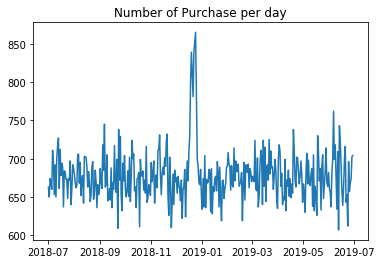

In [190]:
plt.plot(num_of_purch_per_day['DATE'], num_of_purch_per_day['Count'])
plt.title('Number of Purchase per day')

### From the chart we can see there is an increase in purchases in December and a break in late December.

(array([737029., 737033., 737037., 737041., 737045., 737049., 737053.,
        737057., 737060.]),
 <a list of 9 Text xticklabel objects>)

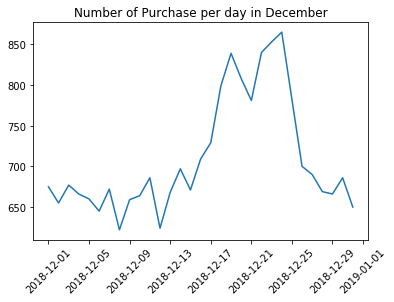

In [191]:
# take a close look at December's transactions
dec_trans = num_of_purch_per_day[(num_of_purch_per_day.DATE.dt.month ==12) & (num_of_purch_per_day.DATE.dt.year==2018)]
plt.plot(dec_trans.DATE, dec_trans.Count)
plt.title('Number of Purchase per day in December')
plt.xticks(rotation = 45)

### we can see that the increase was during Christmas. Now that we can move to other features such as pack size or brands. 

## 2. Adding New Features

In [192]:
# pack size
new_tran_df['PROD_SIZE']=new_tran_df['PROD_NAME'].apply(lambda x: re.findall(r'\d+',x))
# to check whether have more than one numbers in the PROD_size
new_tran_df[new_tran_df.PROD_SIZE.str.len() >1]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_SIZE


In [193]:
# then we like to get rid of the list parathesis
new_tran_df['PROD_SIZE'] = new_tran_df['PROD_SIZE'].apply(lambda x: x[0]).astype('int')

In [194]:
# get the prodsize summary
new_tran_df['PROD_SIZE'].describe()

count    246740.000000
mean        175.583521
std          59.432118
min          70.000000
25%         150.000000
50%         170.000000
75%         175.000000
max         380.000000
Name: PROD_SIZE, dtype: float64

### The largest size is 380g and the smallest size is 70g

(array([  4515.,  23841.,  71532., 106133.,  12309.,   3169.,   6285.,
             0.,  12540.,   6416.]),
 array([ 70., 101., 132., 163., 194., 225., 256., 287., 318., 349., 380.]),
 <a list of 10 Patch objects>)

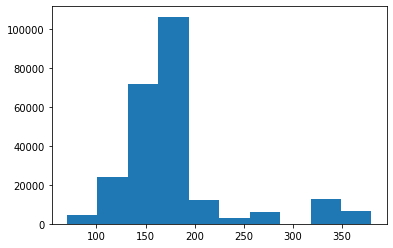

In [195]:
# prod size distribution
plt.hist(new_tran_df['PROD_SIZE'])

In [196]:
# get brand names
new_tran_df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_SIZE
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150


### Some of the brand names look like they are of the same brands - such as RED and
RRD, which are both Red Rock Deli chips. Let's combine these together.

In [197]:
new_tran_df['PROD_NAME'].apply(lambda x: x.split(' ')[0]).unique()


array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'French', 'RRD', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

In [198]:
new_tran_df['Brand'] = new_tran_df['PROD_NAME'].apply(lambda x: x.split(' ')[0])

In [199]:
# we can see Dorito equals to Doritos, Red = RRD, Infuzions = Infzns, Smiths = Smith
d = {'red':'RRD','ww':'WOOLWORTHS','ncc':'NATURAL','snbts':'SUNBITES','infzns':'INFUZIONS','smith':'SMITHS','dorito':'DORITOS','grain':'GRNWVES'}


In [200]:
new_tran_df['Brand'] = new_tran_df['Brand'].str.lower().replace(d).str.capitalize()
new_tran_df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_SIZE,Brand
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,Ccs
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle


## 3. EDA of the customer dataset

In [201]:
purch_behav_data.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [202]:
data_info(purch_behav_data)

There are 72637 rows and 3 columns.
-------------head of the data------------------
   LYLTY_CARD_NBR               LIFESTAGE PREMIUM_CUSTOMER
0            1000   YOUNG SINGLES/COUPLES          Premium
1            1002   YOUNG SINGLES/COUPLES       Mainstream
2            1003          YOUNG FAMILIES           Budget
3            1004   OLDER SINGLES/COUPLES       Mainstream
4            1005  MIDAGE SINGLES/COUPLES       Mainstream
-------------description of the data------------------
        LYLTY_CARD_NBR LIFESTAGE PREMIUM_CUSTOMER
count     7.263700e+04     72637            72637
unique             NaN         7                3
top                NaN  RETIREES       Mainstream
freq               NaN     14805            29245
mean      1.361859e+05       NaN              NaN
std       8.989293e+04       NaN              NaN
min       1.000000e+03       NaN              NaN
25%       6.620200e+04       NaN              NaN
50%       1.340400e+05       NaN              NaN
75%    

### Based on this table, we can figure out that quantium customers mainly have<font color = 'red'> 7</font> different lifestage and <font color ="red">3 </font> types of customer segments. And customers who are in the lifestage of <span style="color:red">retirees</span>  or <span style="color:red">mainstream</span> customer segments have the highest number of consumption

In [203]:
lifestages = purch_behav_data['LIFESTAGE'].unique()
print("The 7 lifestages are:", lifestages)

The 7 lifestages are: ['YOUNG SINGLES/COUPLES' 'YOUNG FAMILIES' 'OLDER SINGLES/COUPLES'
 'MIDAGE SINGLES/COUPLES' 'NEW FAMILIES' 'OLDER FAMILIES' 'RETIREES']


In [204]:
qvi_tran_data[qvi_tran_data["STORE_NBR"]==226].count()

DATE              2022
STORE_NBR         2022
LYLTY_CARD_NBR    2022
TXN_ID            2022
PROD_NBR          2022
PROD_NAME         2022
PROD_QTY          2022
TOT_SALES         2022
dtype: int64

In [205]:
prem_cust = purch_behav_data['PREMIUM_CUSTOMER'].unique()

In [206]:
print('The 3 different premium customers are:',prem_cust)

The 3 different premium customers are: ['Premium' 'Mainstream' 'Budget']


In [207]:
purch_behav_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [208]:
lifestage =purch_behav_data['LIFESTAGE'].value_counts()

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

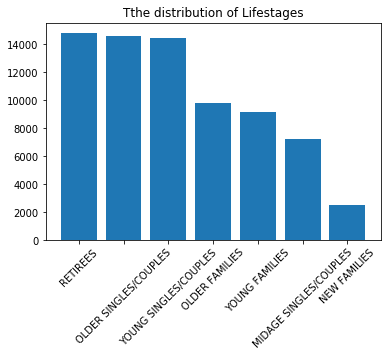

In [209]:
plt.bar(lifestage.index, lifestage )
plt.title("Tthe distribution of Lifestages")
plt.xticks(rotation = 45)

In [210]:
cust_segs = purch_behav_data['PREMIUM_CUSTOMER'].value_counts()

([0, 1, 2], <a list of 3 Text xticklabel objects>)

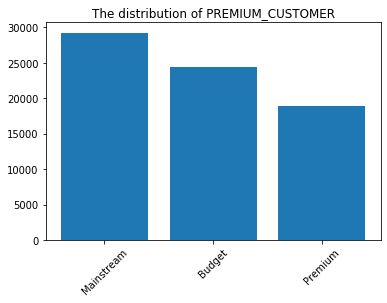

In [212]:
plt.bar(cust_segs.index, cust_segs )
plt.title("The distribution of PREMIUM_CUSTOMER")
plt.xticks(rotation = 45)

## Merge customer dataset and transaction dataset

In [213]:
merged_data = pd.merge(new_tran_df, purch_behav_data, how = 'left', on ='LYLTY_CARD_NBR')

In [214]:
new_tran_df.shape, purch_behav_data.shape,merged_data.shape

((246740, 10), (72637, 3), (246740, 12))

In [215]:
#so there is no duplicate create.
merged_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_SIZE,Brand,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,Ccs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle,MIDAGE SINGLES/COUPLES,Budget


In [216]:
# checking for null customers and whether any transactions did not have a matched customer
merged_data.isna().sum()

DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PROD_SIZE           0
Brand               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [217]:
merged_data.to_csv('merged_data.csv')

##  The customer's total spend over the period and total spend for each transaction to understand what proportion of their grocery spend is on chips 


In [219]:
customer_spend = merged_data.groupby(['PREMIUM_CUSTOMER','LIFESTAGE'])['TOT_SALES'].sum().reset_index(name = 'Total Sales')

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

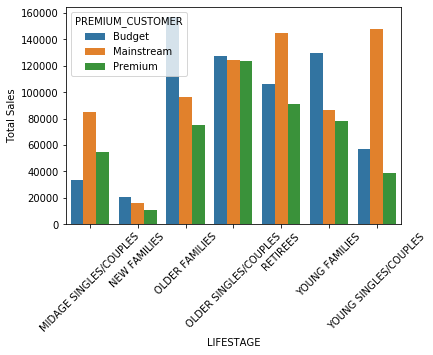

In [228]:
sns.barplot(x = 'LIFESTAGE', y = 'Total Sales', hue = 'PREMIUM_CUSTOMER',data = customer_spend)
plt.xticks(rotation = 45)

### Sales are coming mainly from Budget - older families, Mainstream - young singles/couples, and Mainstream - retirees


In [243]:
## Number of customers by LIFESTAGE and PREMIUM_CUSTOMER
num_of_customer = merged_data.groupby(['PREMIUM_CUSTOMER','LIFESTAGE'])['LYLTY_CARD_NBR'].nunique().reset_index(name = '# of Customer')

In [244]:
num_of_customer.head()

,PREMIUM_CUSTOMER,LIFESTAGE,# of Customer
0,Budget,MIDAGE SINGLES/COUPLES,1474
1,Budget,NEW FAMILIES,1087
2,Budget,OLDER FAMILIES,4611
3,Budget,OLDER SINGLES/COUPLES,4849
4,Budget,RETIREES,4385


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

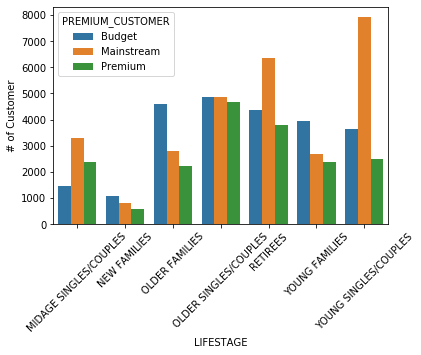

In [245]:
sns.barplot(x = 'LIFESTAGE', y = '# of Customer', hue = 'PREMIUM_CUSTOMER',data = num_of_customer)
plt.xticks(rotation = 45)

### There are more Mainstream - young singles/couples and Mainstream - retirees who buy chips. This contributes to there being more sales to these customer segments but this is not a major driver for the Budget - Older families segment.


In [261]:
# Average number of units per customer by LIFESTAGE and PREMIUM_CUSTOMER
avg_units_per_customer = merged_data.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).agg({'LYLTY_CARD_NBR': 'nunique', 'PROD_QTY':'sum'}).reset_index()

In [265]:
avg_units_per_customer['avg'] =round(avg_units_per_customer['PROD_QTY'] /avg_units_per_customer['LYLTY_CARD_NBR'],2)

In [266]:
avg_units_per_customer.head()

,PREMIUM_CUSTOMER,LIFESTAGE,LYLTY_CARD_NBR,PROD_QTY,avg
0,Budget,MIDAGE SINGLES/COUPLES,1474,8883,6.03
1,Budget,NEW FAMILIES,1087,5241,4.82
2,Budget,OLDER FAMILIES,4611,41853,9.08
3,Budget,OLDER SINGLES/COUPLES,4849,32883,6.78
4,Budget,RETIREES,4385,26932,6.14


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

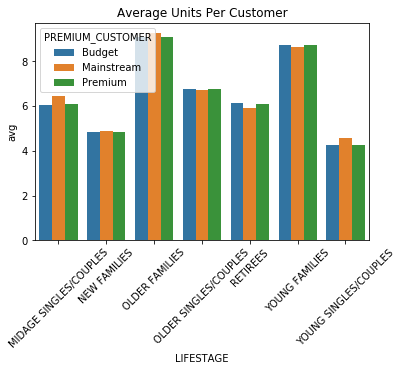

In [267]:
sns.barplot(x = 'LIFESTAGE', y = 'avg', hue = 'PREMIUM_CUSTOMER',data = avg_units_per_customer).set_title('Average Units Per Customer')
plt.xticks(rotation = 45)

### Older families and young families in general buy more chips per customer


In [268]:
# Average price per unit by LIFESTAGE and PREMIUM_CUSTOMER
sale_unit = merged_data.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).agg({'TOT_SALES': 'sum', 'PROD_QTY':'sum'}).reset_index()

In [269]:
sale_unit['avg_price_per_unit'] = round(sale_unit['TOT_SALES']/sale_unit['PROD_QTY'],2)

In [270]:
sale_unit.head()

,PREMIUM_CUSTOMER,LIFESTAGE,TOT_SALES,PROD_QTY,avg_price_per_unit
0,Budget,MIDAGE SINGLES/COUPLES,33345.70,8883,3.75
1,Budget,NEW FAMILIES,20607.45,5241,3.93
2,Budget,OLDER FAMILIES,156863.75,41853,3.75
3,Budget,OLDER SINGLES/COUPLES,127833.60,32883,3.89
4,Budget,RETIREES,105916.30,26932,3.93


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

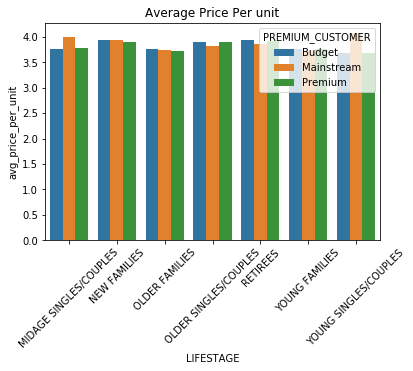

In [271]:
sns.barplot(x = 'LIFESTAGE', y = 'avg_price_per_unit', hue = 'PREMIUM_CUSTOMER',data = sale_unit).set_title('Average Price Per unit')
plt.xticks(rotation = 45)

### As the difference in average price per unit isn't large, we can check if this difference is statistically different.


## 4. Independent t-test

In [281]:
# Performing an independent t‐test between mainstream vs premium 
# and budget midage and young singles and couples.
main_data= sale_unit[(sale_unit['PREMIUM_CUSTOMER'] =='Mainstream' )& sale_unit['LIFESTAGE'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"])]['avg_price_per_unit']
bud_or_premium = sale_unit[(sale_unit['PREMIUM_CUSTOMER'] !='Mainstream' )& sale_unit['LIFESTAGE'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"])]['avg_price_per_unit']

In [282]:
ttest_ind(main_data, bud_or_premium,equal_var=True)

Ttest_indResult(statistic=7.253836856895203, pvalue=0.001917632602386518)

### Since the value of p < 0.05 e reject the null hypothesis and as t = 37.832 we canconclude that the unit price for mainstream,young and mid-age singles and couples is significantly higher than that of budget or premium, young and midage singles and couples.

In [305]:
# let we see what kinds of chips mainstream young and mig-age singles and couples are like.
main_young_brand = merged_data[(merged_data['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES','MIDAGE SINGLES/COUPLES']) )& (merged_data['PREMIUM_CUSTOMER']=='Mainstream')]\
    .groupby(['LIFESTAGE','Brand'])['PROD_QTY'].sum().reset_index(name = 'TOTAL QTY')\
    .sort_values(by = 'TOTAL QTY',ascending = False)

In [306]:
main_young_brand.head()

,LIFESTAGE,Brand,TOTAL QTY
29,YOUNG SINGLES/COUPLES,Kettle,7172
25,YOUNG SINGLES/COUPLES,Doritos,4447
31,YOUNG SINGLES/COUPLES,Pringles,4326
9,MIDAGE SINGLES/COUPLES,Kettle,4085
33,YOUNG SINGLES/COUPLES,Smiths,3491


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text xticklabel objects>)

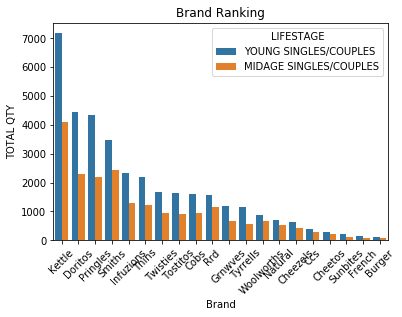

In [309]:
sns.barplot(x = 'Brand' , y = 'TOTAL QTY', hue = 'LIFESTAGE',data = main_young_brand).set_title('Brand Ranking')
plt.xticks(rotation = 45)

### From this table, we cam see that for mainstream young and midage singles/couples their favorite chip band is Kettle. Besides, they also like Doritos, Pringles and Smiths.

## 5. Affinity analysis using apriori and association rules
   

In [317]:
### Next we would like see whether these brands have co-occurrence relationships among customers' activities. TXN_ID is used as one order
basket_band = merged_data[(merged_data['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES','MIDAGE SINGLES/COUPLES']) )& (merged_data['PREMIUM_CUSTOMER']=='Mainstream')]\
    .groupby(['LIFESTAGE','TXN_ID','Brand'])['PROD_QTY'].sum().unstack().reset_index().fillna(0)
    

In [319]:
basket_band.head()

Brand,LIFESTAGE,TXN_ID,Burger,Ccs,Cheetos,Cheezels,Cobs,Doritos,French,Grnwves,...,Natural,Pringles,Rrd,Smiths,Sunbites,Thins,Tostitos,Twisties,Tyrrells,Woolworths
0,MIDAGE SINGLES/COUPLES,6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MIDAGE SINGLES/COUPLES,58,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MIDAGE SINGLES/COUPLES,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,MIDAGE SINGLES/COUPLES,63,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,MIDAGE SINGLES/COUPLES,64,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [325]:
basket_band.iloc[:,2:]=basket_band.iloc[:,2:].astype('int')

In [332]:
mid = basket_band[basket_band['LIFESTAGE']=='MIDAGE SINGLES/COUPLES'].iloc[:,2:]
youn = basket_band[basket_band['LIFESTAGE']=='YOUNG SINGLES/COUPLES'].iloc[:,2:]

In [391]:
def associate_rule(dataset):
    filter = (dataset >1)
    dataset[filter] =1
    frequent_itemsets = apriori(dataset, min_support=0.01, use_colnames=True)
    #print(frequent_itemsets)
    rules = association_rules(frequent_itemsets, metric="lift")
    return rules

In [380]:
mid.shape, youn.shape

((11034, 20), (19482, 20))

In [381]:
associate_rule(mid)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [382]:
associate_rule(youn)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [383]:
associate_rule(basket_band.iloc[:,2:])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [386]:
md = merged_data.groupby(['TXN_ID','Brand'])['PROD_QTY'].sum().unstack().reset_index().fillna(0).iloc[:,1:].astype('int')

In [392]:
associate_rule(md)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


### With that, we can see there is no significant relationship between different bands

#  6. Conclusion


### Let's also find out if our target segment tends to buy larger packs of chips.

In [426]:
pack_per_purchase = merged_data[(merged_data['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES','MIDAGE SINGLES/COUPLES']) )& (merged_data['PREMIUM_CUSTOMER']=='Mainstream')].groupby(['LIFESTAGE','TXN_ID'])['PROD_QTY'].sum().reset_index(name = 'QTY')
pack = pack_per_purchase.groupby(['LIFESTAGE','QTY'])['QTY'].count().reset_index(name = 'frequence')

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

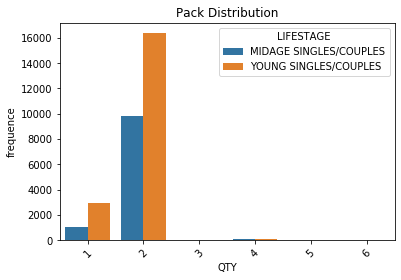

In [429]:
sns.barplot(x = 'QTY',y='frequence', hue = 'LIFESTAGE', data = pack).set_title('Pack Distribution')
plt.xticks(rotation = 45)

## With this we can see our target customers tend to buy 2 packs at a time

##  Q: Preferred pack size compared to the rest of the population

In [463]:
merged_data['target'] = merged_data.apply(\
        lambda x: 1\
        if x['LIFESTAGE'] in ['YOUNG SINGLES/COUPLES','MIDAGE SINGLES/COUPLES'] and x['PREMIUM_CUSTOMER']=='Mainstream'\
                  else 0, axis=1)

In [466]:
size = merged_data.groupby(['target','PROD_SIZE'])['PROD_QTY'].sum().reset_index(name = 'QTY')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text xticklabel objects>)

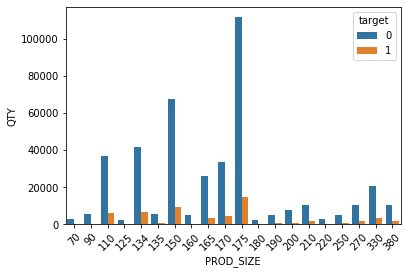

In [467]:
sns.barplot(x = 'PROD_SIZE',y='QTY', hue = 'target', data = size)
plt.xticks(rotation = 45)

## From the table we can see that our customers tend to buy 175g size of chips